# L1 norm prior experiment

This code attempts to learn the 4D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_4D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim =4

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 19.81589698791504
iteration 0 loss 1497.8397216796875


iteration 5000 loss 0.01624370738863945


iteration 10000 loss 0.0039506028406322


iteration 15000 loss 0.0022909820545464754


iteration 20000 loss 0.001221505575813353


iteration 25000 loss 0.0008373170858249068


iteration 30000 loss 0.0006216010078787804


iteration 35000 loss 0.0004994237096980214


iteration 40000 loss 0.00040859932778403163


iteration 45000 loss 0.0003510903043206781


iteration 50000 loss 0.0003184916276950389


iteration 55000 loss 0.00029042985988780856


iteration 60000 loss 0.00026643459568731487


iteration 65000 loss 0.0002743212098721415


iteration 70000 loss 0.00022863392950966954


iteration 75000 loss 0.00022275967057794333


iteration 80000 loss 0.0001929901773110032


iteration 85000 loss 0.00018273209570907056


iteration 90000 loss 0.0001674376253504306


iteration 95000 loss 0.00015750282909721136


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0001486743421992287


iteration 105000 loss 0.00014370384451467544


iteration 110000 loss 0.00013461103662848473


iteration 115000 loss 0.00012762556434608996


iteration 120000 loss 0.0001221247366629541


iteration 125000 loss 0.00011723548959707841


iteration 130000 loss 0.00011209367221454158


iteration 135000 loss 0.00010748842760222033


iteration 140000 loss 0.00010379322338849306


iteration 145000 loss 9.960489842342213e-05


iteration 150000 loss 9.60707911872305e-05


iteration 155000 loss 9.335019421996549e-05


iteration 160000 loss 9.049348591361195e-05


iteration 165000 loss 8.78536666277796e-05


iteration 170000 loss 8.536592940799892e-05


iteration 175000 loss 8.45180475153029e-05


iteration 180000 loss 8.063178393058479e-05


iteration 185000 loss 7.836167787900195e-05


iteration 190000 loss 7.629872561665252e-05


iteration 195000 loss 7.448629912687466e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 7.266984903253615e-05


iteration 205000 loss 7.164721318986267e-05


iteration 210000 loss 6.92096509737894e-05


iteration 215000 loss 6.722888065269217e-05


iteration 220000 loss 6.522839976241812e-05


iteration 225000 loss 6.343290442600846e-05


iteration 230000 loss 6.172749272082001e-05


iteration 235000 loss 6.0167061747051775e-05


iteration 240000 loss 5.86722708248999e-05


iteration 245000 loss 5.724247603211552e-05


iteration 250000 loss 5.587475243373774e-05


iteration 255000 loss 5.46336559636984e-05


iteration 260000 loss 5.338474511518143e-05


iteration 265000 loss 5.214545672060922e-05


iteration 270000 loss 5.1048682507826015e-05


iteration 275000 loss 4.997408905182965e-05


iteration 280000 loss 4.887872273684479e-05


iteration 285000 loss 4.782895484822802e-05


iteration 290000 loss 4.6901819587219507e-05


iteration 295000 loss 4.596414873958565e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 4.505651304498315e-05


iteration 305000 loss 4.4850956328446046e-05


iteration 310000 loss 4.3989286496071145e-05


iteration 315000 loss 4.3109528633067384e-05


iteration 320000 loss 4.22719786001835e-05


iteration 325000 loss 4.146836727159098e-05


iteration 330000 loss 4.0689908928470686e-05


iteration 335000 loss 3.99344862671569e-05


iteration 340000 loss 3.9203689084388316e-05


iteration 345000 loss 3.8486348785227165e-05


iteration 350000 loss 3.778114842134528e-05


iteration 355000 loss 3.708947770064697e-05


iteration 360000 loss 3.64168627129402e-05


iteration 365000 loss 3.576426024665125e-05


iteration 370000 loss 3.513119736453518e-05


iteration 375000 loss 3.452297460171394e-05


iteration 380000 loss 3.39366051775869e-05


iteration 385000 loss 3.3361146051902324e-05


iteration 390000 loss 3.27986927004531e-05


iteration 395000 loss 3.2244664907921106e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.1704490538686514e-05


iteration 405000 loss 3.160568667226471e-05


iteration 410000 loss 3.148127143504098e-05


iteration 415000 loss 3.136624945909716e-05


iteration 420000 loss 3.1254927307600155e-05


iteration 425000 loss 3.11460426019039e-05


iteration 430000 loss 3.103880226262845e-05


iteration 435000 loss 3.0932944355299696e-05


iteration 440000 loss 3.0828581657260656e-05


iteration 445000 loss 3.072525578318164e-05


iteration 450000 loss 3.062286850763485e-05


iteration 455000 loss 3.052125975955278e-05


iteration 460000 loss 3.042028401978314e-05


iteration 465000 loss 3.0320219593704678e-05


iteration 470000 loss 3.022063901880756e-05


iteration 475000 loss 3.0121540476102382e-05


iteration 480000 loss 3.0023278668522835e-05


iteration 485000 loss 2.992539702972863e-05


iteration 490000 loss 2.9828284823452123e-05


iteration 495000 loss 2.9731649192399345e-05


L2 loss -- Plot

loss -1.2830421924591064


loss -102.21502685546875


loss -201.75685119628906


loss -286.8966064453125


loss -344.51312255859375


loss -387.12799072265625


loss -417.6993713378906


loss -439.09490966796875


loss -453.8570251464844


loss -463.405029296875


loss -469.3031005859375


loss -473.7035827636719


loss -477.8070983886719


loss -482.0650329589844


loss -486.6253356933594


loss -491.5140380859375


loss -496.7016296386719


loss -502.1357421875


loss -507.7601623535156


loss -513.5247802734375


loss -519.3892822265625


loss -525.3234252929688


loss -531.30517578125


loss -537.319091796875


loss -543.3546142578125


loss -549.4043579101562


loss -555.46337890625


loss -561.5276489257812


loss -567.5948486328125


loss -573.66357421875


loss -579.7335205078125


loss -585.806396484375


loss -591.88037109375


loss -597.9555053710938


loss -604.03125


loss -610.1072387695312


loss -616.1815795898438


loss -622.253662109375


loss -628.3248901367188


loss -634.395751953125


final mse:  0.02004276216030121
max, min: 18.418224 -18.403063
loss -1.2830421924591064


loss -102.17298889160156


loss -201.59210205078125


loss -286.8524169921875


loss -344.643310546875


loss -387.2705078125


loss -417.6279296875


loss -439.14031982421875


loss -453.8887939453125


loss -463.40679931640625


loss -469.36248779296875


loss -473.7547302246094


loss -477.74237060546875


loss -481.7884216308594


loss -486.05303955078125


loss -490.577392578125


loss -495.3507080078125


loss -500.33843994140625


loss -505.4976806640625


loss -510.7865295410156


loss -516.168701171875


loss -521.6153564453125


loss -527.1046142578125


loss -532.620361328125


loss -538.1509399414062


loss -543.6878662109375


loss -549.22509765625


loss -554.7571411132812


loss -560.2814331054688


loss -565.795654296875


loss -571.2982177734375


loss -576.7871704101562


loss -582.2607421875


loss -587.7169799804688


loss -593.1546630859375


loss -598.5709228515625


loss -603.9637451171875


loss -609.33056640625


loss -614.669921875


loss -619.9796142578125


final mse:  0.01647893153131008
max, min: 18.204224 -18.441368


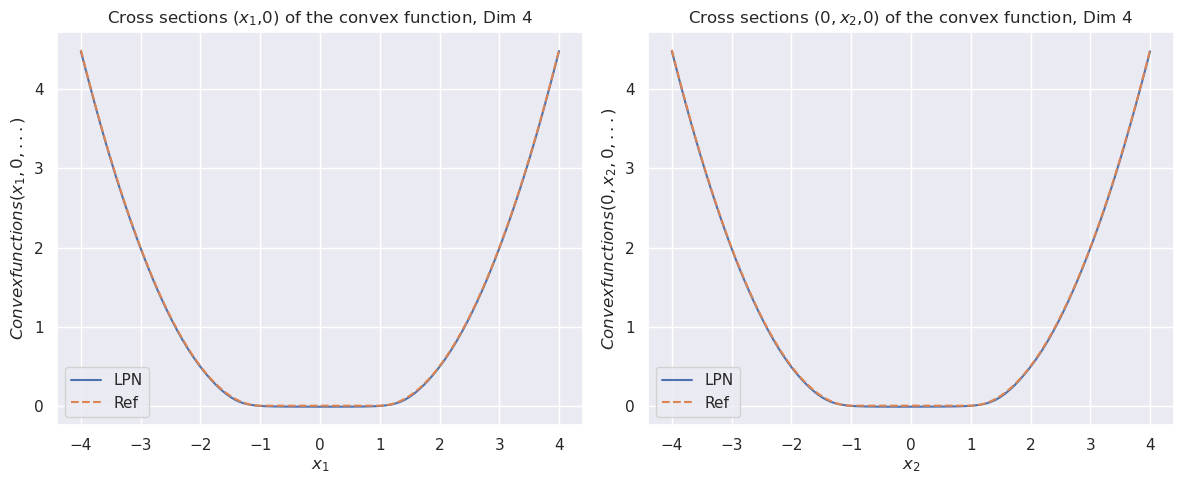

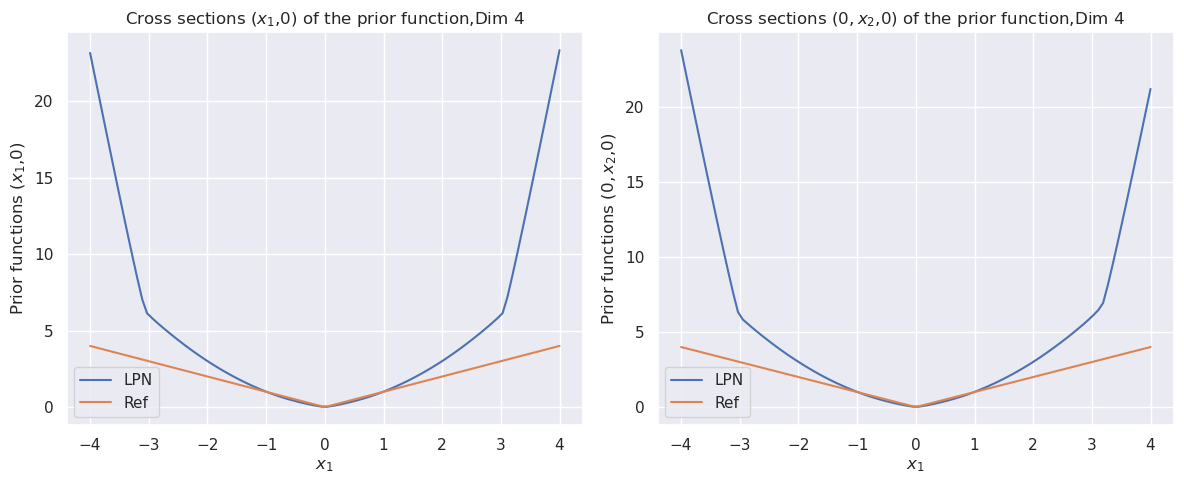

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 109.11942291259766
iteration 0 loss 309.11444091796875


iteration 5000 loss 0.0065360828302800655


iteration 10000 loss 0.0030735915061086416


iteration 15000 loss 0.0023900310043245554


iteration 20000 loss 0.0020539374090731144


iteration 25000 loss 0.0016862883931025863


iteration 30000 loss 0.0014936580555513501


iteration 35000 loss 0.0014050750760361552


iteration 40000 loss 0.0013033975847065449


iteration 45000 loss 0.0012422455474734306


iteration 50000 loss 0.0011261154431849718


iteration 55000 loss 0.0010419137543067336


iteration 60000 loss 0.0010019609471783042


iteration 65000 loss 0.0008979840786196291


iteration 70000 loss 0.0008915169746614993


iteration 75000 loss 0.0008029870805330575


iteration 80000 loss 0.0007705512107349932


iteration 85000 loss 0.0007293865201063454


iteration 90000 loss 0.0007510242285206914


iteration 95000 loss 0.0006706828135065734


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0006477193674072623


iteration 105000 loss 0.0006309696473181248


iteration 110000 loss 0.0006058552535250783


iteration 115000 loss 0.0005845615523867309


iteration 120000 loss 0.0005644934717565775


iteration 125000 loss 0.0005460716201923788


iteration 130000 loss 0.000529032782651484


iteration 135000 loss 0.0005146038602106273


iteration 140000 loss 0.0004994769697077572


iteration 145000 loss 0.00048573067761026323


iteration 150000 loss 0.00047236098907887936


iteration 155000 loss 0.0004596802464220673


iteration 160000 loss 0.00044801473268307745


iteration 165000 loss 0.0004368964000605047


iteration 170000 loss 0.0004265632596798241


iteration 175000 loss 0.0004166217695455998


iteration 180000 loss 0.0004071518196724355


iteration 185000 loss 0.0003983988717664033


iteration 190000 loss 0.0003894692927133292


iteration 195000 loss 0.0003817897813860327


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.00037401955341920257


iteration 205000 loss 0.0003692092723213136


iteration 210000 loss 0.00036160749732516706


iteration 215000 loss 0.00035361223854124546


iteration 220000 loss 0.0003461241431068629


iteration 225000 loss 0.00033871017512865365


iteration 230000 loss 0.00033229749533347785


iteration 235000 loss 0.0003254619659855962


iteration 240000 loss 0.0003197384939994663


iteration 245000 loss 0.00031391423544846475


iteration 250000 loss 0.000308040005620569


iteration 255000 loss 0.0003026673221029341


iteration 260000 loss 0.0002975829120259732


iteration 265000 loss 0.00029244780307635665


iteration 270000 loss 0.00028777323313988745


iteration 275000 loss 0.00028314042720012367


iteration 280000 loss 0.00027839551330544055


iteration 285000 loss 0.000274279504083097


iteration 290000 loss 0.00027018587570637465


iteration 295000 loss 0.0002658875018823892


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0002620683517307043


iteration 305000 loss 0.0002609156654216349


iteration 310000 loss 0.0002583373570814729


iteration 315000 loss 0.00025588550488464534


iteration 320000 loss 0.000253527017775923


iteration 325000 loss 0.0002512371283955872


iteration 330000 loss 0.00024899333948269486


iteration 335000 loss 0.00024679399211890996


iteration 340000 loss 0.00024463998852297664


iteration 345000 loss 0.00024253227456938475


iteration 350000 loss 0.0002404603874310851


iteration 355000 loss 0.00023843221424613148


iteration 360000 loss 0.0002364456158829853


iteration 365000 loss 0.0002344913373235613


iteration 370000 loss 0.0002325661771465093


iteration 375000 loss 0.0002306764799868688


iteration 380000 loss 0.00022881836048327386


iteration 385000 loss 0.00022699324472341686


iteration 390000 loss 0.0002251835830975324


iteration 395000 loss 0.00022340698342304677


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.00022166143753565848


iteration 405000 loss 0.00022146890114527196


iteration 410000 loss 0.00022121543588582426


iteration 415000 loss 0.00022097243345342577


iteration 420000 loss 0.00022073506261222064


iteration 425000 loss 0.000220502755837515


iteration 430000 loss 0.0002202727773692459


iteration 435000 loss 0.00022004672791808844


iteration 440000 loss 0.00021982249745633453


iteration 445000 loss 0.00021960119192954153


iteration 450000 loss 0.00021938137069810182


iteration 455000 loss 0.00021916363039053977


iteration 460000 loss 0.00021894740348216146


iteration 465000 loss 0.00021873247169423848


iteration 470000 loss 0.00021851858764421195


iteration 475000 loss 0.00021830544574186206


iteration 480000 loss 0.00021809405006933957


iteration 485000 loss 0.00021788410958833992


iteration 490000 loss 0.00021767453290522099


iteration 495000 loss 0.00021746625134255737


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


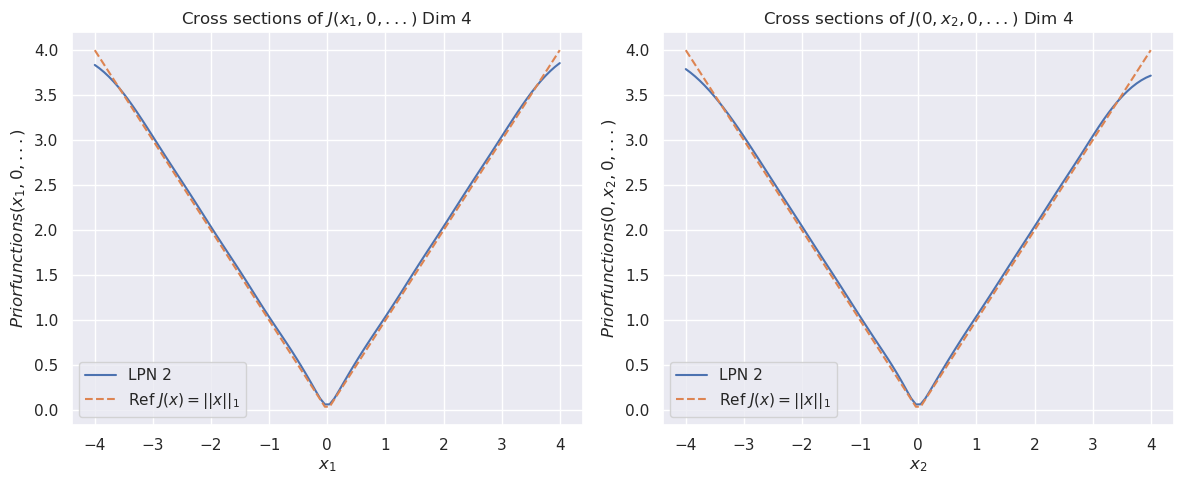

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)